### Cab-Driver Agent

In [1]:
# Load libraries
import math
import time
import pickle
import random
import datetime
import numpy as np
from collections import deque 

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Environment - Test Run  

In [3]:
driver = CabDriver()
print("Number of Locations:", 5)
print("Action Space (pick, drop):", len(driver.action_space))
print(driver.action_space)
print("State Space: (current-location, time, day):", len(driver.state_space))
print(driver.state_space[:10]+driver.state_space[-10:] )
print("Initial State:", len(driver.state_init))
print(driver.state_init)
state_code = driver.state_encod_arch2(driver.state_init)
print("State One Hot Encoded:", state_code.shape)
print(state_code)
possible_action_idx, available_actions = driver.requests(driver.state_init)
print("Possible action idx", possible_action_idx)
print("Sample actions:", len(available_actions))
print(available_actions)
action = available_actions[np.random.choice(len(available_actions))]
print("Current action:", action)
print("Immediate Reward:", driver.reward_func(driver.state_init, action, np.load("TM.npy")))
print("Next State:", driver.next_state_func(driver.state_init, action, np.load("TM.npy")))

Number of Locations: 5
Action Space (pick, drop): 21
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3)]
State Space: (current-location, time, day): 840
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 1, 0), (0, 1, 1), (0, 1, 2), (4, 22, 4), (4, 22, 5), (4, 22, 6), (4, 23, 0), (4, 23, 1), (4, 23, 2), (4, 23, 3), (4, 23, 4), (4, 23, 5), (4, 23, 6)]
Initial State: 3
(3, 7, 1)
State One Hot Encoded: (36,)
[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Possible action idx [0, 2, 3, 8, 14]
Sample actions: 5
[(0, 0), (0, 2), (0, 3), (1, 4), (3, 1)]
Current action: (0, 3)
Immediate Reward: 9.0
Next State: ((3, 10, 1), False)


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_Matrix = np.load("TM.npy")
Time_Matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence

In [4]:
# Initialise states tracker to check for convergence
def initialise_tracking_states():
    state_actions = [((2, 3, 4), (0, 0)), ((3, 22, 6), (0, 4)),
                     ((4, 14, 6), (0, 4)), ((3, 0, 0), (3, 4)),
                     ((1, 18, 0), (1, 4)), ((0, 5, 3), (0, 0))]
    for state, action in state_actions:
        states_track[state] = {}
        states_track[state][action] = []

In [5]:
# Store states tracker to check for convergence
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                states_track[state][action].append(Q_dict[state][action])

In [6]:
def save_training_loss(logs):
    training_loss.append(logs)

In [7]:
# Defining a function to save the Q-dictionary/reward/timetrack as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
# Defining a function to load the Q-dictionary/reward/timetrack from a pickle file
def load_obj(name):
    obj = None
    with open(name + '.pkl', 'rb') as f:
        obj = pickle.load(f)
    return obj

### Agent Class - Architecture 2

1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [148]:
class DQNAgent:
    
    env = CabDriver()
    
    def __init__(self, state_size=36, action_size=21):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.5
        self.learning_rate =  0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.001
        self.epsilon_min = 0.000001
        self.batch_size = 64
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim=self.state_size, kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, episodes):
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment  
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * episode)
        z = np.random.random()
        if z>epsilon:
            # best action - from possible action 
            return self.greedy_action(state), True
        else:
            #randomly select the actions 
            return self.random_action(state), False
            
    def greedy_action(self, state):
        state_encod = env.state_encod_arch2(state).reshape(-1, self.state_size)
        actions = self.model.predict(state_encod)[0]
        action_idx, available_actions = env.requests(state)
        action_max_idx = np.argmax(actions[action_idx])
        return available_actions[action_max_idx]

    def random_action(self, state):
        action_idx, available_actions = env.requests(state)
        return available_actions[np.random.choice(len(available_actions))]
    
    
    def append_sample(self, state, action, reward, next_state):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory - [(s,a,r,s'),(s,a,r,s') .... ]
            mini_batch = np.array(random.sample(self.memory, self.batch_size))
            
            actions, rewards = np.array(list(mini_batch[:, 1])), list(mini_batch[:, 2])
            current_state = np.array(list(mini_batch[:, 0]))
            next_state = np.array(list(mini_batch[:, 3]))
            
            # 1.  Encode current state and next state batch
            current_state_input = env.state_batch_encode_archII(current_state)
            next_state_input = env.state_batch_encode_archII(next_state)
            
            # 2.1. Predict Q-values for the next states to calculate future reward
            q_vals = self.model.predict(next_state_input) 
            # 2.2. Predict Q-values for the current states to calculate 
            target = self.model.predict(current_state_input)
            
            # 3. Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
            for i in range(self.batch_size):
                action_idx, available_actions = env.requests(state)
                sample_output_actions = q_vals[i][action_idx]
                action_max_idx = np.argmax(sample_output_actions)
                update_qval = rewards[i]+self.discount_factor*sample_output_actions[action_max_idx]
                target[i][action_idx[action_max_idx]] = update_qval
                
                # save q-values for tracking
                if state not in Q_dict:
                    Q_dict[state] = {}
                Q_dict[state][available_actions[action_max_idx]] = update_qval

            # 4. Fit your model and track the loss values
            history = self.model.fit(current_state_input, target)
            save_training_loss(history)
            
    def save(self, name):
        self.model.save(name+'.h5', save_format='h5')

### DQN Block

In [152]:
start_time = time.time()

# Hyper param - number of episodes
EPISODES = 5000

# Tracking params
track_time = []
track_train_time = []
track_action_time = []
training_loss = []
greedy_actions = []
Q_dict = {}
states_track = {}
initialise_tracking_states()
total_steps = 0
TRACK_CHECKPOINT = 10

# Call the DQN agent
agent = DQNAgent()

for episode in range(EPISODES):
    
    # Call the environment
    env = CabDriver()
    # Call initial state
    state = env.state_init
    
    terminal = False
    greedy_count = 0
    action_time = 0
    count=0
    while not terminal:
        count+=1
        total_steps+=1
        
        ta = time.time()
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action, greedy = agent.get_action(state, episode)
        if greedy:
            greedy_count+=1
        action_time += time.time()-ta
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_Matrix)
        next_state, terminal = env.next_state_func(state, action, Time_Matrix)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state)
        state = next_state
        if count%50 == 0:
            # 4. Train the model by calling function agent.train_model
            ts = time.time()
            agent.train_model()
            track_train_time.append(time.time()-ts)
    track_action_time.append(action_time)
    greedy_actions.append(greedy_count)
    print(episode, ' :: ', time.time()-start_time)
    # 5. Keep a track of rewards, Q-values, loss+
    if episode % TRACK_CHECKPOINT == 0:
        track_time.append(time.time()-start_time)
        save_tracking_states()
        
    if episode%TRACK_CHECKPOINT == 0:
        agent.save('cab-driver')

elapsed_time = datetime.timedelta(seconds=time.time()-start_time)
print("Elapsed time :", elapsed_time)

<ipython-input-148-b338ee6792c9>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mini_batch = np.array(random.sample(self.memory, self.batch_size))


2/2 [==============================] - 0s 2ms/step - loss: 10.2130
0  ::  0.8159372806549072
2/2 [==============================] - 0s 5ms/step - loss: 11.2689
1  ::  1.3013684749603271
2/2 [==============================] - 0s 2ms/step - loss: 9.1914
2  ::  1.7539124488830566
2/2 [==============================] - 0s 3ms/step - loss: 11.3391
3  ::  2.138789415359497
2/2 [==============================] - 0s 2ms/step - loss: 5.9120
4  ::  2.549720525741577
2/2 [==============================] - 0s 4ms/step - loss: 8.6452
5  ::  2.9437320232391357
2/2 [==============================] - 0s 2ms/step - loss: 12.0779
6  ::  3.498636245727539
2/2 [==============================] - 0s 2ms/step - loss: 8.9975
7  ::  4.200793266296387
2/2 [==============================] - 0s 2ms/step - loss: 10.4912
8  ::  4.625411033630371
2/2 [==============================] - 0s 4ms/step - loss: 9.1491
9  ::  5.002645015716553
2/2 [==============================] - 0s 4ms/step - loss: 7.8509
10  ::  5.54706

2/2 [==============================] - 0s 4ms/step - loss: 7.2456
103  ::  55.24196243286133
2/2 [==============================] - 0s 4ms/step - loss: 6.5894
104  ::  55.83454656600952
2/2 [==============================] - 0s 2ms/step - loss: 6.9222
105  ::  56.386863231658936
2/2 [==============================] - 0s 2ms/step - loss: 6.2775
106  ::  56.90811038017273
2/2 [==============================] - 0s 2ms/step - loss: 5.3804
107  ::  57.75239372253418
2/2 [==============================] - 0s 985us/step - loss: 6.5261
108  ::  58.12043118476868
2/2 [==============================] - 0s 2ms/step - loss: 7.1440
109  ::  58.64183521270752
2/2 [==============================] - 0s 3ms/step - loss: 6.7392
110  ::  59.253360748291016
2/2 [==============================] - 0s 2ms/step - loss: 8.2316
111  ::  59.9024760723114
2/2 [==============================] - 0s 2ms/step - loss: 6.1123
112  ::  60.52764844894409
2/2 [==============================] - 0s 3ms/step - loss: 6.0473
1

2/2 [==============================] - 0s 2ms/step - loss: 4.9269
205  ::  125.68943095207214
2/2 [==============================] - 0s 2ms/step - loss: 6.6443
206  ::  126.53673696517944
2/2 [==============================] - 0s 3ms/step - loss: 6.7526
207  ::  127.10578966140747
2/2 [==============================] - 0s 4ms/step - loss: 5.2496
208  ::  128.00839948654175
2/2 [==============================] - 0s 2ms/step - loss: 5.1873
209  ::  128.80064916610718
2/2 [==============================] - 0s 2ms/step - loss: 6.5572
210  ::  129.4317364692688
2/2 [==============================] - 0s 3ms/step - loss: 4.3298
211  ::  130.16317081451416
2/2 [==============================] - 0s 2ms/step - loss: 5.6734
212  ::  130.9181170463562
2/2 [==============================] - 0s 2ms/step - loss: 5.9253
213  ::  131.6863877773285
2/2 [==============================] - 0s 4ms/step - loss: 6.3351
214  ::  132.74308943748474
2/2 [==============================] - 0s 2ms/step - loss: 6.56

2/2 [==============================] - 0s 2ms/step - loss: 5.8222
307  ::  214.76006817817688
2/2 [==============================] - 0s 4ms/step - loss: 6.3744
308  ::  215.80377960205078
2/2 [==============================] - 0s 4ms/step - loss: 6.0159
309  ::  217.1588044166565
2/2 [==============================] - 0s 4ms/step - loss: 5.3962
310  ::  217.9480335712433
2/2 [==============================] - 0s 2ms/step - loss: 6.6988
311  ::  219.68160009384155
2/2 [==============================] - 0s 2ms/step - loss: 4.9014
312  ::  220.75498294830322
2/2 [==============================] - 0s 2ms/step - loss: 4.5558
313  ::  221.73016500473022
2/2 [==============================] - 0s 4ms/step - loss: 8.5083
314  ::  223.00418138504028
2/2 [==============================] - 0s 2ms/step - loss: 5.8568
315  ::  224.11754488945007
2/2 [==============================] - 0s 3ms/step - loss: 6.9482
316  ::  225.3700761795044
2/2 [==============================] - 0s 2ms/step - loss: 7.67

2/2 [==============================] - 0s 2ms/step - loss: 4.8399
410  ::  322.1637134552002
2/2 [==============================] - 0s 1ms/step - loss: 6.1031
411  ::  323.41349697113037
2/2 [==============================] - 0s 3ms/step - loss: 6.9346
412  ::  324.1571364402771
2/2 [==============================] - 0s 2ms/step - loss: 6.5241
413  ::  325.5440366268158
2/2 [==============================] - 0s 2ms/step - loss: 6.2377
414  ::  326.22901129722595
2/2 [==============================] - 0s 3ms/step - loss: 6.1611
415  ::  327.20319294929504
2/2 [==============================] - 0s 3ms/step - loss: 6.8205
416  ::  328.04633951187134
2/2 [==============================] - 0s 2ms/step - loss: 5.4980
417  ::  329.2892994880676
2/2 [==============================] - 0s 4ms/step - loss: 5.8838
418  ::  330.4578318595886
2/2 [==============================] - 0s 2ms/step - loss: 5.9669
419  ::  332.0986421108246
2/2 [==============================] - 0s 2ms/step - loss: 4.6381


2/2 [==============================] - 0s 4ms/step - loss: 5.3543
461  ::  380.81553649902344
2/2 [==============================] - 0s 2ms/step - loss: 5.7602
462  ::  381.63421154022217
2/2 [==============================] - 0s 2ms/step - loss: 6.5521
463  ::  383.1118104457855
2/2 [==============================] - 0s 2ms/step - loss: 5.5883
464  ::  384.75930428504944
2/2 [==============================] - 0s 2ms/step - loss: 4.8085
465  ::  386.03127551078796
2/2 [==============================] - 0s 4ms/step - loss: 6.0034
466  ::  387.30565643310547
2/2 [==============================] - 0s 3ms/step - loss: 6.1433
467  ::  388.53790259361267
2/2 [==============================] - 0s 3ms/step - loss: 6.3024
468  ::  390.16721868515015
2/2 [==============================] - 0s 2ms/step - loss: 6.1534
469  ::  391.35544657707214
2/2 [==============================] - 0s 2ms/step - loss: 6.3899
470  ::  392.71547174453735
2/2 [==============================] - 0s 3ms/step - loss: 5.

512  ::  446.3121654987335
2/2 [==============================] - 0s 1ms/step - loss: 6.5149
513  ::  447.6876451969147
2/2 [==============================] - 0s 4ms/step - loss: 5.9580
514  ::  448.74155378341675
2/2 [==============================] - 0s 4ms/step - loss: 6.6846
515  ::  449.8175072669983
2/2 [==============================] - 0s 2ms/step - loss: 5.8544
516  ::  451.1369938850403
2/2 [==============================] - 0s 3ms/step - loss: 6.9301
517  ::  452.7529263496399
2/2 [==============================] - 0s 4ms/step - loss: 5.5506
518  ::  453.91890382766724
2/2 [==============================] - 0s 3ms/step - loss: 6.0629
519  ::  454.9177157878876
2/2 [==============================] - 0s 2ms/step - loss: 8.0393
520  ::  456.22846722602844
2/2 [==============================] - 0s 3ms/step - loss: 5.5849
521  ::  457.19839906692505
2/2 [==============================] - 0s 2ms/step - loss: 7.4086
522  ::  458.71900272369385
2/2 [==============================] -

2/2 [==============================] - 0s 2ms/step - loss: 7.8995
615  ::  586.9770209789276
2/2 [==============================] - 0s 3ms/step - loss: 7.6581
616  ::  589.1791315078735
2/2 [==============================] - 0s 2ms/step - loss: 6.2555
617  ::  590.5455312728882
2/2 [==============================] - 0s 4ms/step - loss: 5.4883
618  ::  592.3202784061432
2/2 [==============================] - 0s 2ms/step - loss: 6.8251
619  ::  593.4612579345703
2/2 [==============================] - 0s 2ms/step - loss: 5.2342
620  ::  594.5748736858368
2/2 [==============================] - 0s 4ms/step - loss: 5.9796
621  ::  596.1451749801636
2/2 [==============================] - 0s 3ms/step - loss: 7.7243
622  ::  597.5020639896393
2/2 [==============================] - 0s 2ms/step - loss: 6.8239
623  ::  599.3582179546356
2/2 [==============================] - 0s 4ms/step - loss: 6.3636
624  ::  601.8087139129639
2/2 [==============================] - 0s 2ms/step - loss: 5.6286
625 

2/2 [==============================] - 0s 2ms/step - loss: 5.9583
667  ::  669.7405874729156
2/2 [==============================] - 0s 3ms/step - loss: 5.0462
668  ::  671.4825167655945
2/2 [==============================] - 0s 2ms/step - loss: 8.3515
669  ::  673.2546243667603
2/2 [==============================] - 0s 3ms/step - loss: 4.2623
670  ::  675.3906512260437
2/2 [==============================] - 0s 3ms/step - loss: 5.9076
671  ::  676.853360414505
2/2 [==============================] - 0s 2ms/step - loss: 4.9182
672  ::  678.4593331813812
2/2 [==============================] - 0s 2ms/step - loss: 4.8863
673  ::  679.6889171600342
2/2 [==============================] - 0s 2ms/step - loss: 5.8863
674  ::  681.4432711601257
2/2 [==============================] - 0s 2ms/step - loss: 9.0153
675  ::  682.7472884654999
2/2 [==============================] - 0s 2ms/step - loss: 5.1304
676  ::  684.3701655864716
2/2 [==============================] - 0s 2ms/step - loss: 8.0206
677  

2/2 [==============================] - 0s 2ms/step - loss: 6.8505
770  ::  835.961930513382
2/2 [==============================] - 0s 4ms/step - loss: 7.9344
771  ::  837.2794508934021
2/2 [==============================] - 0s 3ms/step - loss: 5.5366
772  ::  838.9375350475311
2/2 [==============================] - 0s 4ms/step - loss: 7.3523
773  ::  840.931004524231
2/2 [==============================] - 0s 2ms/step - loss: 5.2593
774  ::  842.4259948730469
2/2 [==============================] - 0s 3ms/step - loss: 6.1610
775  ::  843.9405450820923
2/2 [==============================] - 0s 4ms/step - loss: 7.2636
776  ::  846.0441012382507
2/2 [==============================] - 0s 2ms/step - loss: 5.5932
777  ::  847.8844776153564
2/2 [==============================] - 0s 2ms/step - loss: 5.9234
778  ::  849.4175245761871
2/2 [==============================] - 0s 2ms/step - loss: 6.0107
779  ::  850.972333908081
2/2 [==============================] - 0s 2ms/step - loss: 5.6524
780  ::

2/2 [==============================] - 0s 2ms/step - loss: 8.9633
873  ::  1023.8341436386108
2/2 [==============================] - 0s 5ms/step - loss: 7.4944
874  ::  1025.2182397842407
2/2 [==============================] - 0s 2ms/step - loss: 6.7363
875  ::  1026.500454902649
2/2 [==============================] - 0s 4ms/step - loss: 7.1699
876  ::  1029.0287036895752
2/2 [==============================] - 0s 4ms/step - loss: 6.1459
877  ::  1030.9613449573517
2/2 [==============================] - 0s 2ms/step - loss: 5.6946
878  ::  1032.9892673492432
2/2 [==============================] - 0s 3ms/step - loss: 5.6682
879  ::  1034.8672251701355
2/2 [==============================] - 0s 2ms/step - loss: 6.4371
880  ::  1036.9980871677399
2/2 [==============================] - 0s 2ms/step - loss: 6.0527
881  ::  1039.6588099002838
2/2 [==============================] - 0s 2ms/step - loss: 6.7875
882  ::  1041.4799864292145
2/2 [==============================] - 0s 4ms/step - loss: 5.

2/2 [==============================] - 0s 4ms/step - loss: 5.6849
975  ::  1225.944800376892
2/2 [==============================] - 0s 2ms/step - loss: 8.2313
976  ::  1227.6833634376526
2/2 [==============================] - 0s 2ms/step - loss: 6.3062
977  ::  1228.9900217056274
2/2 [==============================] - 0s 2ms/step - loss: 6.4967
978  ::  1231.0084481239319
2/2 [==============================] - 0s 2ms/step - loss: 6.4493
979  ::  1232.878172636032
2/2 [==============================] - 0s 2ms/step - loss: 4.8614
980  ::  1235.4912343025208
2/2 [==============================] - 0s 4ms/step - loss: 6.8663
981  ::  1237.4621176719666
2/2 [==============================] - 0s 2ms/step - loss: 8.3868
982  ::  1239.1021909713745
2/2 [==============================] - 0s 2ms/step - loss: 5.3228
983  ::  1241.225016593933
2/2 [==============================] - 0s 2ms/step - loss: 4.7931
984  ::  1242.5774698257446
2/2 [==============================] - 0s 2ms/step - loss: 4.50

2/2 [==============================] - 0s 4ms/step - loss: 6.8528
1077  ::  1447.4908893108368
2/2 [==============================] - 0s 2ms/step - loss: 6.3386
1078  ::  1449.862280845642
2/2 [==============================] - 0s 2ms/step - loss: 6.4076
1079  ::  1452.4689164161682
2/2 [==============================] - 0s 2ms/step - loss: 4.8504
1080  ::  1454.3667097091675
2/2 [==============================] - 0s 2ms/step - loss: 5.2292
1081  ::  1455.9632618427277
2/2 [==============================] - 0s 4ms/step - loss: 7.6136
1082  ::  1458.218986272812
2/2 [==============================] - 0s 2ms/step - loss: 5.1851
1083  ::  1459.9141061306
2/2 [==============================] - 0s 2ms/step - loss: 7.4655
1084  ::  1462.7894983291626
2/2 [==============================] - 0s 3ms/step - loss: 7.9316
1085  ::  1465.375427722931
2/2 [==============================] - 0s 3ms/step - loss: 6.5212
1086  ::  1468.2582685947418
2/2 [==============================] - 0s 4ms/step - los

2/2 [==============================] - 0s 2ms/step - loss: 7.7041
1128  ::  1566.9453206062317
2/2 [==============================] - 0s 3ms/step - loss: 6.3079
1129  ::  1569.646484375
2/2 [==============================] - 0s 2ms/step - loss: 6.9423
1130  ::  1571.8033351898193
2/2 [==============================] - 0s 2ms/step - loss: 6.4782
1131  ::  1573.9390771389008
2/2 [==============================] - 0s 2ms/step - loss: 4.8872
1132  ::  1576.406768321991
2/2 [==============================] - 0s 2ms/step - loss: 4.9268
1133  ::  1578.770762205124
2/2 [==============================] - 0s 4ms/step - loss: 5.6663
1134  ::  1580.5931260585785
2/2 [==============================] - 0s 4ms/step - loss: 5.8673
1135  ::  1582.8573560714722
2/2 [==============================] - 0s 2ms/step - loss: 5.1442
1136  ::  1584.7803840637207
2/2 [==============================] - 0s 2ms/step - loss: 6.4879
1137  ::  1586.6731293201447
2/2 [==============================] - 0s 2ms/step - los

2/2 [==============================] - 0s 6ms/step - loss: 6.6720
1179  ::  1682.7549695968628
2/2 [==============================] - 0s 6ms/step - loss: 6.4811
1180  ::  1684.984614610672
2/2 [==============================] - 0s 2ms/step - loss: 5.7221
1181  ::  1688.452058315277
2/2 [==============================] - 0s 3ms/step - loss: 6.1311
1182  ::  1691.4952075481415
2/2 [==============================] - 0s 2ms/step - loss: 6.6882
1183  ::  1694.0894107818604
2/2 [==============================] - 0s 2ms/step - loss: 6.0733
1184  ::  1696.6822018623352
2/2 [==============================] - 0s 2ms/step - loss: 5.1514
1185  ::  1698.1671562194824
2/2 [==============================] - 0s 3ms/step - loss: 6.0270
1186  ::  1700.0389621257782
2/2 [==============================] - 0s 3ms/step - loss: 5.4859
1187  ::  1701.748851776123
2/2 [==============================] - 0s 2ms/step - loss: 6.6420
1188  ::  1704.9669947624207
2/2 [==============================] - 0s 2ms/step - 

2/2 [==============================] - 0s 3ms/step - loss: 5.2020
1281  ::  1932.9920763969421
2/2 [==============================] - 0s 2ms/step - loss: 4.9039
1282  ::  1935.6160492897034
2/2 [==============================] - 0s 2ms/step - loss: 6.8192
1283  ::  1938.1729464530945
2/2 [==============================] - 0s 3ms/step - loss: 6.5402
1284  ::  1940.0030426979065
2/2 [==============================] - 0s 2ms/step - loss: 8.8975
1285  ::  1942.4742953777313
2/2 [==============================] - 0s 2ms/step - loss: 7.7204
1286  ::  1944.1759176254272
2/2 [==============================] - 0s 2ms/step - loss: 5.0824
1287  ::  1947.2953324317932
2/2 [==============================] - 0s 2ms/step - loss: 6.6068
1288  ::  1949.2074477672577
2/2 [==============================] - 0s 2ms/step - loss: 6.7677
1289  ::  1951.3111193180084
2/2 [==============================] - 0s 2ms/step - loss: 6.5892
1290  ::  1953.511794090271
2/2 [==============================] - 0s 2ms/step 

2/2 [==============================] - 0s 2ms/step - loss: 6.8658
1332  ::  2056.3679966926575
2/2 [==============================] - 0s 4ms/step - loss: 6.6978
1333  ::  2058.8109951019287
2/2 [==============================] - 0s 2ms/step - loss: 4.9149
1334  ::  2061.3108384609222
2/2 [==============================] - 0s 2ms/step - loss: 8.3388
1335  ::  2063.8796105384827
2/2 [==============================] - 0s 2ms/step - loss: 5.1024
1336  ::  2066.438826084137
2/2 [==============================] - 0s 2ms/step - loss: 7.1360
1337  ::  2069.1615126132965
2/2 [==============================] - 0s 2ms/step - loss: 4.2489
1338  ::  2071.850734233856
2/2 [==============================] - 0s 2ms/step - loss: 6.0462
1339  ::  2074.430648326874
2/2 [==============================] - 0s 2ms/step - loss: 4.4061
1340  ::  2076.97993183136
2/2 [==============================] - 0s 2ms/step - loss: 5.8708
1341  ::  2079.0458652973175
2/2 [==============================] - 0s 2ms/step - lo

2/2 [==============================] - 0s 3ms/step - loss: 6.3339
1434  ::  2312.160630941391
2/2 [==============================] - 0s 2ms/step - loss: 5.3637
1435  ::  2315.0941591262817
2/2 [==============================] - 0s 2ms/step - loss: 4.5247
1436  ::  2317.327065706253
2/2 [==============================] - 0s 4ms/step - loss: 5.2788
1437  ::  2319.0871107578278
2/2 [==============================] - 0s 995us/step - loss: 6.4333
1438  ::  2321.0096576213837
2/2 [==============================] - 0s 5ms/step - loss: 7.2782
1439  ::  2323.355965614319
2/2 [==============================] - 0s 3ms/step - loss: 6.9397
1440  ::  2325.693001270294
2/2 [==============================] - 0s 2ms/step - loss: 5.0143
1441  ::  2328.2528669834137
2/2 [==============================] - 0s 2ms/step - loss: 5.2240
1442  ::  2330.7845191955566
2/2 [==============================] - 0s 3ms/step - loss: 5.7226
1443  ::  2333.110584974289
2/2 [==============================] - 0s 2ms/step - 

2/2 [==============================] - 0s 2ms/step - loss: 6.3902
1536  ::  2574.929913520813
2/2 [==============================] - 0s 3ms/step - loss: 5.8232
1537  ::  2577.6726512908936
2/2 [==============================] - 0s 2ms/step - loss: 6.5311
1538  ::  2580.534721136093
2/2 [==============================] - 0s 2ms/step - loss: 6.2910
1539  ::  2582.6698803901672
2/2 [==============================] - 0s 2ms/step - loss: 5.8207
1540  ::  2585.725675344467
2/2 [==============================] - 0s 4ms/step - loss: 5.8623
1541  ::  2587.843895673752
2/2 [==============================] - 0s 2ms/step - loss: 7.5816
1542  ::  2591.392390727997
2/2 [==============================] - 0s 2ms/step - loss: 5.8355
1543  ::  2594.997816324234
2/2 [==============================] - 0s 2ms/step - loss: 6.9520
1544  ::  2597.90700006485
2/2 [==============================] - 0s 2ms/step - loss: 4.5207
1545  ::  2600.879912376404
2/2 [==============================] - 0s 3ms/step - loss: 

2/2 [==============================] - 0s 3ms/step - loss: 5.6464
1638  ::  2863.602895259857
2/2 [==============================] - 0s 2ms/step - loss: 6.2997
1639  ::  2865.7291753292084
2/2 [==============================] - 0s 2ms/step - loss: 6.8556
1640  ::  2868.6707243919373
2/2 [==============================] - 0s 3ms/step - loss: 8.3453
1641  ::  2871.0936226844788
2/2 [==============================] - 0s 3ms/step - loss: 7.6095
1642  ::  2873.5562772750854
2/2 [==============================] - 0s 2ms/step - loss: 5.5583
1643  ::  2877.058445453644
2/2 [==============================] - 0s 1ms/step - loss: 4.9921
1644  ::  2879.8206448554993
2/2 [==============================] - 0s 2ms/step - loss: 5.1481
1645  ::  2882.2523612976074
2/2 [==============================] - 0s 2ms/step - loss: 6.8146
1646  ::  2885.0858607292175
2/2 [==============================] - 0s 9ms/step - loss: 6.5410
1647  ::  2888.2838191986084
2/2 [==============================] - 0s 2ms/step -

2/2 [==============================] - 0s 3ms/step - loss: 7.1074
1689  ::  3004.3852636814117
2/2 [==============================] - 0s 2ms/step - loss: 5.1560
1690  ::  3007.042395591736
2/2 [==============================] - 0s 2ms/step - loss: 5.8597
1691  ::  3010.3222024440765
2/2 [==============================] - 0s 2ms/step - loss: 9.5383
1692  ::  3013.2262365818024
2/2 [==============================] - 0s 1ms/step - loss: 7.3052
1693  ::  3016.1901881694794
2/2 [==============================] - 0s 6ms/step - loss: 7.2208
1694  ::  3018.655460357666
2/2 [==============================] - 0s 2ms/step - loss: 5.7242
1695  ::  3020.890234708786
2/2 [==============================] - 0s 4ms/step - loss: 6.4027
1696  ::  3022.8186926841736
2/2 [==============================] - 0s 2ms/step - loss: 6.0035
1697  ::  3025.3769438266754
2/2 [==============================] - 0s 2ms/step - loss: 5.3427
1698  ::  3028.070165872574
2/2 [==============================] - 0s 2ms/step - l

2/2 [==============================] - 0s 4ms/step - loss: 4.6722
1791  ::  3308.251589536667
2/2 [==============================] - 0s 2ms/step - loss: 5.5734
1792  ::  3311.397550344467
2/2 [==============================] - 0s 1ms/step - loss: 4.5486
1793  ::  3313.952038049698
2/2 [==============================] - 0s 2ms/step - loss: 3.9148
1794  ::  3317.2896699905396
2/2 [==============================] - 0s 4ms/step - loss: 6.2569
1795  ::  3321.252093553543
2/2 [==============================] - 0s 2ms/step - loss: 6.2497
1796  ::  3323.898084640503
2/2 [==============================] - 0s 3ms/step - loss: 5.9581
1797  ::  3327.3678064346313
2/2 [==============================] - 0s 2ms/step - loss: 4.9239
1798  ::  3330.592286348343
2/2 [==============================] - 0s 2ms/step - loss: 5.4317
1799  ::  3334.6281538009644
2/2 [==============================] - 0s 2ms/step - loss: 4.6348
1800  ::  3337.154008626938
2/2 [==============================] - 0s 1ms/step - loss

2/2 [==============================] - 0s 2ms/step - loss: 5.3818
1893  ::  3630.9514269828796
2/2 [==============================] - 0s 3ms/step - loss: 5.2110
1894  ::  3634.424357652664
2/2 [==============================] - 0s 2ms/step - loss: 7.1588
1895  ::  3637.7662529945374
2/2 [==============================] - 0s 3ms/step - loss: 6.1371
1896  ::  3641.477192878723
2/2 [==============================] - 0s 3ms/step - loss: 8.9219
1897  ::  3645.107880592346
2/2 [==============================] - 0s 3ms/step - loss: 5.4223
1898  ::  3648.6395728588104
2/2 [==============================] - 0s 2ms/step - loss: 6.3175
1899  ::  3652.137112379074
2/2 [==============================] - 0s 3ms/step - loss: 4.1110
1900  ::  3655.9211282730103
2/2 [==============================] - 0s 2ms/step - loss: 7.1605
1901  ::  3659.31884598732
2/2 [==============================] - 0s 2ms/step - loss: 5.8351
1902  ::  3662.3269691467285
2/2 [==============================] - 0s 3ms/step - los

2/2 [==============================] - 0s 1ms/step - loss: 4.7971
1995  ::  3936.5772309303284
2/2 [==============================] - 0s 2ms/step - loss: 5.4328
1996  ::  3939.1590881347656
2/2 [==============================] - 0s 2ms/step - loss: 7.3130
1997  ::  3942.0601720809937
2/2 [==============================] - 0s 2ms/step - loss: 6.8092
1998  ::  3945.1014516353607
2/2 [==============================] - 0s 4ms/step - loss: 4.1782
1999  ::  3948.7798652648926
2/2 [==============================] - 0s 3ms/step - loss: 6.6829
2000  ::  3952.1674048900604
2/2 [==============================] - 0s 999us/step - loss: 5.7506
2001  ::  3955.030208349228
2/2 [==============================] - 0s 2ms/step - loss: 7.3355
2002  ::  3958.534928560257
2/2 [==============================] - 0s 2ms/step - loss: 4.6649
2003  ::  3962.4368131160736
2/2 [==============================] - 0s 996us/step - loss: 5.4956
2004  ::  3965.904757499695
2/2 [==============================] - 0s 2ms/ste

2/2 [==============================] - 0s 2ms/step - loss: 5.5347
2096  ::  4245.578078508377
2/2 [==============================] - 0s 1ms/step - loss: 3.7594
2097  ::  4248.548073768616
2/2 [==============================] - 0s 2ms/step - loss: 6.0609
2098  ::  4251.443817853928
2/2 [==============================] - 0s 2ms/step - loss: 6.3853
2099  ::  4253.776733875275
2/2 [==============================] - 0s 2ms/step - loss: 6.2169
2100  ::  4257.269657611847
2/2 [==============================] - 0s 2ms/step - loss: 7.0887
2101  ::  4260.584490776062
2/2 [==============================] - 0s 2ms/step - loss: 8.5627
2102  ::  4264.411111354828
2/2 [==============================] - 0s 2ms/step - loss: 7.1827
2103  ::  4267.744297742844
2/2 [==============================] - 0s 2ms/step - loss: 7.0090
2104  ::  4271.43262720108
2/2 [==============================] - 0s 2ms/step - loss: 5.8513
2105  ::  4275.328644037247
2/2 [==============================] - 0s 3ms/step - loss: 6.

2/2 [==============================] - 0s 1ms/step - loss: 6.4483
2198  ::  4574.348029613495
2/2 [==============================] - 0s 2ms/step - loss: 6.1207
2199  ::  4577.140034675598
2/2 [==============================] - 0s 2ms/step - loss: 6.9201
2200  ::  4580.09961771965
2/2 [==============================] - 0s 2ms/step - loss: 6.5620
2201  ::  4583.522253990173
2/2 [==============================] - 0s 2ms/step - loss: 6.4686
2202  ::  4586.603631019592
2/2 [==============================] - 0s 1ms/step - loss: 6.9110
2203  ::  4589.372553348541
2/2 [==============================] - 0s 1ms/step - loss: 6.2497
2204  ::  4592.671046257019
2/2 [==============================] - 0s 999us/step - loss: 4.8617
2205  ::  4595.5149393081665
2/2 [==============================] - 0s 2ms/step - loss: 5.1778
2206  ::  4599.448016166687
2/2 [==============================] - 0s 2ms/step - loss: 5.3963
2207  ::  4601.9247579574585
2/2 [==============================] - 0s 2ms/step - loss

2/2 [==============================] - 0s 1ms/step - loss: 5.4803
2300  ::  4898.7657063007355
2/2 [==============================] - 0s 1ms/step - loss: 4.8213
2301  ::  4902.232635259628
2/2 [==============================] - 0s 2ms/step - loss: 5.3832
2302  ::  4905.893041849136
2/2 [==============================] - 0s 1ms/step - loss: 5.8170
2303  ::  4909.54078745842
2/2 [==============================] - 0s 2ms/step - loss: 6.0397
2304  ::  4913.875138759613
2/2 [==============================] - 0s 1ms/step - loss: 6.0623
2305  ::  4916.881037473679
2/2 [==============================] - 0s 998us/step - loss: 4.3204
2306  ::  4919.782423257828
2/2 [==============================] - 0s 2ms/step - loss: 5.5276
2307  ::  4922.701630830765
2/2 [==============================] - 0s 2ms/step - loss: 5.0099
2308  ::  4926.347605466843
2/2 [==============================] - 0s 2ms/step - loss: 4.4623
2309  ::  4930.056968212128
2/2 [==============================] - 0s 3ms/step - loss:

2/2 [==============================] - 0s 2ms/step - loss: 5.7157
2402  ::  5245.799160480499
2/2 [==============================] - 0s 1ms/step - loss: 4.8510
2403  ::  5249.065356969833
2/2 [==============================] - 0s 999us/step - loss: 6.6369
2404  ::  5253.007551193237
2/2 [==============================] - 0s 3ms/step - loss: 5.8512
2405  ::  5256.753440380096
2/2 [==============================] - 0s 2ms/step - loss: 4.2348
2406  ::  5260.50602889061
2/2 [==============================] - 0s 2ms/step - loss: 3.7257
2407  ::  5263.48993229866
2/2 [==============================] - 0s 2ms/step - loss: 5.2972
2408  ::  5266.869614362717
2/2 [==============================] - 0s 2ms/step - loss: 5.4538
2409  ::  5269.801975250244
2/2 [==============================] - 0s 2ms/step - loss: 6.0579
2410  ::  5272.550185680389
2/2 [==============================] - 0s 2ms/step - loss: 7.2770
2411  ::  5275.4298787117
2/2 [==============================] - 0s 3ms/step - loss: 5.2

2/2 [==============================] - 0s 1ms/step - loss: 5.6372
2504  ::  5594.547761440277
2/2 [==============================] - 0s 2ms/step - loss: 5.8031
2505  ::  5598.765158176422
2/2 [==============================] - 0s 999us/step - loss: 5.4849
2506  ::  5602.495323181152
2/2 [==============================] - 0s 2ms/step - loss: 5.3104
2507  ::  5605.696696519852
2/2 [==============================] - 0s 2ms/step - loss: 8.4592
2508  ::  5608.894095659256
2/2 [==============================] - 0s 2ms/step - loss: 6.5544
2509  ::  5612.427141666412
2/2 [==============================] - 0s 2ms/step - loss: 5.8204
2510  ::  5615.38358092308
2/2 [==============================] - 0s 2ms/step - loss: 5.9433
2511  ::  5618.576436519623
2/2 [==============================] - 0s 996us/step - loss: 4.9316
2512  ::  5622.0291929244995
2/2 [==============================] - 0s 2ms/step - loss: 7.1745
2513  ::  5625.168100833893
2/2 [==============================] - 0s 2ms/step - los

2/2 [==============================] - 0s 2ms/step - loss: 4.6198
2606  ::  5951.611682891846
2/2 [==============================] - 0s 2ms/step - loss: 5.3606
2607  ::  5955.831367969513
2/2 [==============================] - 0s 2ms/step - loss: 3.7868
2608  ::  5959.848753452301
2/2 [==============================] - 0s 2ms/step - loss: 5.4689
2609  ::  5963.3463180065155
2/2 [==============================] - 0s 2ms/step - loss: 5.2262
2610  ::  5966.825289011002
2/2 [==============================] - 0s 2ms/step - loss: 6.8795
2611  ::  5970.219059228897
2/2 [==============================] - 0s 2ms/step - loss: 4.3022
2612  ::  5973.759689807892
2/2 [==============================] - 0s 3ms/step - loss: 3.9514
2613  ::  5977.086840391159
2/2 [==============================] - 0s 994us/step - loss: 5.9879
2614  ::  5981.418706178665
2/2 [==============================] - 0s 2ms/step - loss: 7.4739
2615  ::  5984.646988153458
2/2 [==============================] - 0s 2ms/step - loss

2/2 [==============================] - 0s 2ms/step - loss: 8.0484
2708  ::  6328.137887239456
2/2 [==============================] - 0s 2ms/step - loss: 7.6375
2709  ::  6331.478828430176
2/2 [==============================] - 0s 2ms/step - loss: 6.1494
2710  ::  6334.676810026169
2/2 [==============================] - 0s 992us/step - loss: 7.1567
2711  ::  6338.36350774765
2/2 [==============================] - 0s 1ms/step - loss: 5.3056
2712  ::  6342.371672868729
2/2 [==============================] - 0s 3ms/step - loss: 7.2201
2713  ::  6346.13670873642
2/2 [==============================] - 0s 2ms/step - loss: 4.4422
2714  ::  6349.72363615036
2/2 [==============================] - 0s 2ms/step - loss: 7.0877
2715  ::  6352.967143058777
2/2 [==============================] - 0s 2ms/step - loss: 5.8906
2716  ::  6356.12069940567
2/2 [==============================] - 0s 983us/step - loss: 7.4881
2717  ::  6359.935479402542
2/2 [==============================] - 0s 1ms/step - loss: 4

2/2 [==============================] - 0s 2ms/step - loss: 5.0571
2809  ::  6702.420830011368
2/2 [==============================] - 0s 3ms/step - loss: 4.7192
2810  ::  6706.423689365387
2/2 [==============================] - 0s 2ms/step - loss: 6.3460
2811  ::  6710.044260978699
2/2 [==============================] - 0s 2ms/step - loss: 3.7683
2812  ::  6714.7839868068695
2/2 [==============================] - 0s 999us/step - loss: 6.0657
2813  ::  6718.8381333351135
2/2 [==============================] - 0s 2ms/step - loss: 5.6973
2814  ::  6723.349102735519
2/2 [==============================] - 0s 1ms/step - loss: 4.7947
2815  ::  6726.789806842804
2/2 [==============================] - 0s 2ms/step - loss: 7.3453
2816  ::  6730.437077045441
2/2 [==============================] - 0s 997us/step - loss: 4.6041
2817  ::  6735.364716291428
2/2 [==============================] - 0s 2ms/step - loss: 5.4075
2818  ::  6739.660538673401
2/2 [==============================] - 0s 2ms/step - l

2/2 [==============================] - 0s 2ms/step - loss: 3.4136
2910  ::  7104.664039850235
2/2 [==============================] - 0s 1ms/step - loss: 5.1626
2911  ::  7108.090968370438
2/2 [==============================] - 0s 2ms/step - loss: 4.9874
2912  ::  7111.372775793076
2/2 [==============================] - 0s 2ms/step - loss: 4.7101
2913  ::  7115.3206441402435
2/2 [==============================] - 0s 2ms/step - loss: 5.6794
2914  ::  7119.25991153717
2/2 [==============================] - 0s 2ms/step - loss: 5.2726
2915  ::  7123.484133005142
2/2 [==============================] - 0s 3ms/step - loss: 6.3531
2916  ::  7126.92821931839
2/2 [==============================] - 0s 997us/step - loss: 5.1587
2917  ::  7131.49262547493
2/2 [==============================] - 0s 989us/step - loss: 5.3353
2918  ::  7135.976828098297
2/2 [==============================] - 0s 2ms/step - loss: 4.7023
2919  ::  7140.6429278850555
2/2 [==============================] - 0s 2ms/step - loss

2/2 [==============================] - 0s 3ms/step - loss: 4.7988
3012  ::  7529.45209980011
2/2 [==============================] - 0s 3ms/step - loss: 6.9368
3013  ::  7534.094467163086
2/2 [==============================] - 0s 2ms/step - loss: 5.7374
3014  ::  7539.053296804428
2/2 [==============================] - 0s 2ms/step - loss: 5.8972
3015  ::  7544.196578979492
2/2 [==============================] - 0s 2ms/step - loss: 4.2461
3016  ::  7547.885489225388
2/2 [==============================] - 0s 2ms/step - loss: 4.5476
3017  ::  7551.743778705597
2/2 [==============================] - 0s 1ms/step - loss: 4.2142
3018  ::  7556.9780349731445
2/2 [==============================] - 0s 2ms/step - loss: 7.6163
3019  ::  7560.491042852402
2/2 [==============================] - 0s 2ms/step - loss: 7.6118
3020  ::  7564.616459608078
2/2 [==============================] - 0s 998us/step - loss: 6.9140
3021  ::  7569.227979898453
2/2 [==============================] - 0s 2ms/step - loss:

2/2 [==============================] - 0s 2ms/step - loss: 5.4963
3113  ::  7958.609848499298
2/2 [==============================] - 0s 2ms/step - loss: 5.6618
3114  ::  7962.617635250092
2/2 [==============================] - 0s 1ms/step - loss: 8.2652
3115  ::  7967.61274933815
2/2 [==============================] - 0s 3ms/step - loss: 5.1290
3116  ::  7971.7908847332
2/2 [==============================] - 0s 1ms/step - loss: 6.1626
3117  ::  7976.116933584213
2/2 [==============================] - 0s 1ms/step - loss: 6.0734
3118  ::  7980.423344135284
2/2 [==============================] - 0s 2ms/step - loss: 7.9905
3119  ::  7984.856218338013
2/2 [==============================] - 0s 1ms/step - loss: 3.3947
3120  ::  7988.777735233307
2/2 [==============================] - 0s 2ms/step - loss: 4.2796
3121  ::  7992.9881229400635
2/2 [==============================] - 0s 3ms/step - loss: 5.3231
3122  ::  7996.8181681633
2/2 [==============================] - 0s 2ms/step - loss: 5.722

2/2 [==============================] - 0s 999us/step - loss: 7.8897
3215  ::  8400.721158504486
2/2 [==============================] - 0s 1ms/step - loss: 3.6417
3216  ::  8405.683183670044
2/2 [==============================] - 0s 1000us/step - loss: 5.6261
3217  ::  8409.970539093018
2/2 [==============================] - 0s 2ms/step - loss: 7.1894
3218  ::  8414.40370965004
2/2 [==============================] - 0s 2ms/step - loss: 3.9616
3219  ::  8418.158123970032
2/2 [==============================] - 0s 1ms/step - loss: 5.4616
3220  ::  8423.454671144485
2/2 [==============================] - 0s 1ms/step - loss: 6.7363
3221  ::  8428.181152820587
2/2 [==============================] - 0s 2ms/step - loss: 5.5195
3222  ::  8431.930008888245
2/2 [==============================] - 0s 2ms/step - loss: 6.1178
3223  ::  8436.511622667313
2/2 [==============================] - 0s 2ms/step - loss: 6.2260
3224  ::  8441.114906072617
2/2 [==============================] - 0s 2ms/step - los

2/2 [==============================] - 0s 2ms/step - loss: 5.4576
3317  ::  8865.455446958542
2/2 [==============================] - 0s 2ms/step - loss: 5.9798
3318  ::  8870.102797985077
2/2 [==============================] - 0s 2ms/step - loss: 4.3778
3319  ::  8874.646475553513
2/2 [==============================] - 0s 2ms/step - loss: 4.5052
3320  ::  8879.636829137802
2/2 [==============================] - 0s 2ms/step - loss: 5.1986
3321  ::  8884.13762331009
2/2 [==============================] - 0s 2ms/step - loss: 5.8196
3322  ::  8888.823128461838
2/2 [==============================] - 0s 2ms/step - loss: 6.2518
3323  ::  8893.041469335556
2/2 [==============================] - 0s 2ms/step - loss: 3.5730
3324  ::  8897.638794898987
2/2 [==============================] - 0s 2ms/step - loss: 5.0485
3325  ::  8902.080658912659
2/2 [==============================] - 0s 2ms/step - loss: 5.9959
3326  ::  8906.790148735046
2/2 [==============================] - 0s 2ms/step - loss: 4.

2/2 [==============================] - 0s 1ms/step - loss: 6.5477
3418  ::  9330.475848674774
2/2 [==============================] - 0s 2ms/step - loss: 5.4949
3419  ::  9334.590685129166
2/2 [==============================] - 0s 2ms/step - loss: 5.4738
3420  ::  9339.235505342484
2/2 [==============================] - 0s 2ms/step - loss: 6.3138
3421  ::  9343.808872699738
2/2 [==============================] - 0s 1ms/step - loss: 6.0435
3422  ::  9348.25481247902
2/2 [==============================] - 0s 2ms/step - loss: 5.8351
3423  ::  9352.271656513214
2/2 [==============================] - 0s 1000us/step - loss: 5.6671
3424  ::  9357.151623249054
2/2 [==============================] - 0s 2ms/step - loss: 6.0648
3425  ::  9361.632769107819
2/2 [==============================] - 0s 2ms/step - loss: 6.0750
3426  ::  9366.369698047638
2/2 [==============================] - 0s 2ms/step - loss: 8.2633
3427  ::  9371.204603433609
2/2 [==============================] - 0s 2ms/step - loss:

2/2 [==============================] - 0s 2ms/step - loss: 5.2604
3519  ::  9793.581448316574
2/2 [==============================] - 0s 1ms/step - loss: 4.2565
3520  ::  9797.485149383545
2/2 [==============================] - 0s 2ms/step - loss: 4.0219
3521  ::  9801.432683706284
2/2 [==============================] - 0s 2ms/step - loss: 4.4815
3522  ::  9805.022333621979
2/2 [==============================] - 0s 1ms/step - loss: 6.3027
3523  ::  9809.49292588234
2/2 [==============================] - 0s 2ms/step - loss: 4.6920
3524  ::  9813.157228708267
2/2 [==============================] - 0s 1ms/step - loss: 5.1877
3525  ::  9817.143235445023
2/2 [==============================] - 0s 2ms/step - loss: 6.7641
3526  ::  9821.144096374512
2/2 [==============================] - 0s 1ms/step - loss: 5.8091
3527  ::  9824.228342056274
2/2 [==============================] - 0s 2ms/step - loss: 7.9974
3528  ::  9828.572227954865
2/2 [==============================] - 0s 2ms/step - loss: 5.

3569  ::  10004.505240917206
2/2 [==============================] - 0s 2ms/step - loss: 7.7966
3570  ::  10008.736320972443
2/2 [==============================] - 0s 2ms/step - loss: 6.0413
3571  ::  10012.678388595581
2/2 [==============================] - 0s 997us/step - loss: 7.2095
3572  ::  10016.353842496872
2/2 [==============================] - 0s 2ms/step - loss: 6.9396
3573  ::  10019.984085083008
2/2 [==============================] - 0s 1ms/step - loss: 5.2578
3574  ::  10024.968075990677
2/2 [==============================] - 0s 2ms/step - loss: 6.5368
3575  ::  10029.038670301437
2/2 [==============================] - 0s 1000us/step - loss: 6.0727
3576  ::  10033.682743549347
2/2 [==============================] - 0s 3ms/step - loss: 5.1172
3577  ::  10037.859660863876
2/2 [==============================] - 0s 2ms/step - loss: 6.1859
3578  ::  10042.966278553009
2/2 [==============================] - 0s 2ms/step - loss: 4.9084
3579  ::  10047.775038003922
2/2 [===========

2/2 [==============================] - 0s 2ms/step - loss: 4.1772
3670  ::  10500.290095329285
2/2 [==============================] - 0s 2ms/step - loss: 4.7244
3671  ::  10506.113526582718
2/2 [==============================] - 0s 2ms/step - loss: 5.0137
3672  ::  10515.459975481033
2/2 [==============================] - 0s 3ms/step - loss: 5.0154
3673  ::  10522.586572885513
2/2 [==============================] - 0s 2ms/step - loss: 5.2812
3674  ::  10529.043163776398
2/2 [==============================] - 0s 2ms/step - loss: 4.7268
3675  ::  10536.184498786926
2/2 [==============================] - 0s 3ms/step - loss: 4.1939
3676  ::  10541.945665836334
2/2 [==============================] - 0s 4ms/step - loss: 5.2345
3677  ::  10547.592492103577
2/2 [==============================] - 0s 2ms/step - loss: 4.2975
3678  ::  10553.998682498932
2/2 [==============================] - 0s 4ms/step - loss: 5.1437
3679  ::  10560.057268619537
2/2 [==============================] - 0s 2ms/step

2/2 [==============================] - 0s 3ms/step - loss: 8.3418
3770  ::  11118.894535303116
2/2 [==============================] - 0s 2ms/step - loss: 6.3254
3771  ::  11126.19422197342
2/2 [==============================] - 0s 2ms/step - loss: 4.9740
3772  ::  11131.94828915596
2/2 [==============================] - 0s 4ms/step - loss: 6.1393
3773  ::  11138.6322453022
2/2 [==============================] - 0s 2ms/step - loss: 5.6581
3774  ::  11145.095599651337
2/2 [==============================] - 0s 2ms/step - loss: 5.4681
3775  ::  11153.248350381851
2/2 [==============================] - 0s 3ms/step - loss: 3.1457
3776  ::  11158.80274939537
2/2 [==============================] - 0s 3ms/step - loss: 4.2772
3777  ::  11165.168477535248
2/2 [==============================] - 0s 4ms/step - loss: 3.9892
3778  ::  11170.79162979126
2/2 [==============================] - 0s 3ms/step - loss: 4.0449
3779  ::  11177.027358055115
2/2 [==============================] - 0s 4ms/step - los

2/2 [==============================] - 0s 1ms/step - loss: 3.5529
3871  ::  11780.67881846428
2/2 [==============================] - 0s 2ms/step - loss: 5.5133
3872  ::  11787.063115358353
2/2 [==============================] - 0s 2ms/step - loss: 7.4440
3873  ::  11792.778197050095
2/2 [==============================] - 0s 3ms/step - loss: 4.9442
3874  ::  11799.093785047531
2/2 [==============================] - 0s 2ms/step - loss: 5.9484
3875  ::  11806.261639595032
2/2 [==============================] - 0s 1ms/step - loss: 5.8027
3876  ::  11813.185795783997
2/2 [==============================] - 0s 2ms/step - loss: 4.8290
3877  ::  11820.051478147507
2/2 [==============================] - 0s 1ms/step - loss: 5.6763
3878  ::  11826.572535514832
2/2 [==============================] - 0s 4ms/step - loss: 5.1030
3879  ::  11833.34104847908
2/2 [==============================] - 0s 2ms/step - loss: 7.2958
3880  ::  11840.155532836914
2/2 [==============================] - 0s 2ms/step -

2/2 [==============================] - 0s 3ms/step - loss: 6.7566
3971  ::  12442.692510843277
2/2 [==============================] - 0s 3ms/step - loss: 6.7407
3972  ::  12449.502836942673
2/2 [==============================] - 0s 2ms/step - loss: 5.3742
3973  ::  12455.126787185669
2/2 [==============================] - 0s 2ms/step - loss: 4.7778
3974  ::  12461.424942016602
2/2 [==============================] - 0s 2ms/step - loss: 5.0295
3975  ::  12468.214226961136
2/2 [==============================] - 0s 2ms/step - loss: 6.0274
3976  ::  12473.206040143967
2/2 [==============================] - 0s 2ms/step - loss: 4.4894
3977  ::  12479.90659570694
2/2 [==============================] - 0s 2ms/step - loss: 6.4171
3978  ::  12487.27832198143
2/2 [==============================] - 0s 1ms/step - loss: 5.9992
3979  ::  12493.927387237549
2/2 [==============================] - 0s 5ms/step - loss: 5.3412
3980  ::  12500.028400421143
2/2 [==============================] - 0s 3ms/step -

2/2 [==============================] - 0s 2ms/step - loss: 6.3722
4071  ::  13123.07459282875
2/2 [==============================] - 0s 2ms/step - loss: 4.6591
4072  ::  13131.709838867188
2/2 [==============================] - 0s 1ms/step - loss: 7.1753
4073  ::  13139.115066051483
2/2 [==============================] - 0s 3ms/step - loss: 5.3102
4074  ::  13146.559737920761
2/2 [==============================] - 0s 2ms/step - loss: 4.7598
4075  ::  13153.418087720871
2/2 [==============================] - 0s 2ms/step - loss: 6.3784
4076  ::  13159.941087961197
2/2 [==============================] - 0s 3ms/step - loss: 6.8226
4077  ::  13166.447465658188
2/2 [==============================] - 0s 3ms/step - loss: 4.4433
4078  ::  13173.647691488266
2/2 [==============================] - 0s 3ms/step - loss: 3.2185
4079  ::  13179.964674472809
2/2 [==============================] - 0s 2ms/step - loss: 4.4229
4080  ::  13186.725049972534
2/2 [==============================] - 0s 3ms/step 

2/2 [==============================] - 0s 2ms/step - loss: 6.5235
4172  ::  13818.99408531189
2/2 [==============================] - 0s 2ms/step - loss: 5.9045
4173  ::  13824.93755531311
2/2 [==============================] - 0s 2ms/step - loss: 4.5065
4174  ::  13832.705355644226
2/2 [==============================] - 0s 2ms/step - loss: 5.9326
4175  ::  13838.156272649765
2/2 [==============================] - 0s 3ms/step - loss: 4.0220
4176  ::  13846.283348560333
2/2 [==============================] - 0s 3ms/step - loss: 5.7245
4177  ::  13853.225265026093
2/2 [==============================] - 0s 4ms/step - loss: 5.9616
4178  ::  13860.199201107025
2/2 [==============================] - 0s 2ms/step - loss: 4.8296
4179  ::  13866.008968353271
2/2 [==============================] - 0s 3ms/step - loss: 5.2699
4180  ::  13872.597257375717
2/2 [==============================] - 0s 2ms/step - loss: 4.3360
4181  ::  13879.967621326447
2/2 [==============================] - 0s 1ms/step -

2/2 [==============================] - 0s 2ms/step - loss: 5.8284
4223  ::  14167.558138370514
2/2 [==============================] - 0s 2ms/step - loss: 5.9827
4224  ::  14173.869421243668
2/2 [==============================] - 0s 3ms/step - loss: 5.1484
4225  ::  14180.268412590027
2/2 [==============================] - 0s 2ms/step - loss: 6.5687
4226  ::  14187.256942987442
2/2 [==============================] - 0s 4ms/step - loss: 4.2769
4227  ::  14194.091208457947
2/2 [==============================] - 0s 2ms/step - loss: 4.8196
4228  ::  14200.434735774994
2/2 [==============================] - 0s 2ms/step - loss: 6.5720
4229  ::  14207.252606153488
2/2 [==============================] - 0s 2ms/step - loss: 4.1613
4230  ::  14214.856726169586
2/2 [==============================] - 0s 4ms/step - loss: 4.0558
4231  ::  14221.668369293213
2/2 [==============================] - 0s 2ms/step - loss: 5.8478
4232  ::  14230.17797780037
2/2 [==============================] - 0s 2ms/step 

2/2 [==============================] - 0s 3ms/step - loss: 5.7461
4322  ::  14878.792606830597
2/2 [==============================] - 0s 2ms/step - loss: 6.3567
4323  ::  14884.871418952942
2/2 [==============================] - 0s 4ms/step - loss: 4.1683
4324  ::  14892.197088956833
2/2 [==============================] - 0s 2ms/step - loss: 3.6368
4325  ::  14898.868149518967
2/2 [==============================] - 0s 2ms/step - loss: 5.5060
4326  ::  14907.183110952377
2/2 [==============================] - 0s 3ms/step - loss: 6.9902
4327  ::  14915.708692073822
2/2 [==============================] - 0s 2ms/step - loss: 4.7366
4328  ::  14923.56039738655
2/2 [==============================] - 0s 2ms/step - loss: 6.3730
4329  ::  14930.837238788605
2/2 [==============================] - 0s 2ms/step - loss: 6.3054
4330  ::  14938.626008987427
2/2 [==============================] - 0s 2ms/step - loss: 5.2785
4331  ::  14945.202225446701
2/2 [==============================] - 0s 2ms/step 

2/2 [==============================] - 0s 3ms/step - loss: 6.3635
4422  ::  15616.238107919693
2/2 [==============================] - 0s 2ms/step - loss: 6.1987
4423  ::  15624.791439294815
2/2 [==============================] - 0s 2ms/step - loss: 6.9212
4424  ::  15632.640946388245
2/2 [==============================] - 0s 2ms/step - loss: 6.4470
4425  ::  15640.70966911316
2/2 [==============================] - 0s 4ms/step - loss: 5.6988
4426  ::  15648.77051115036
2/2 [==============================] - 0s 3ms/step - loss: 3.7610
4427  ::  15655.393377780914
2/2 [==============================] - 0s 3ms/step - loss: 6.1005
4428  ::  15662.358438968658
2/2 [==============================] - 0s 2ms/step - loss: 5.9526
4429  ::  15670.321894407272
2/2 [==============================] - 0s 4ms/step - loss: 4.9779
4430  ::  15678.735717773438
2/2 [==============================] - 0s 4ms/step - loss: 3.9678
4431  ::  15686.888155937195
2/2 [==============================] - 0s 2ms/step -

2/2 [==============================] - 0s 3ms/step - loss: 5.3420
4523  ::  16371.941308259964
2/2 [==============================] - 0s 2ms/step - loss: 4.6095
4524  ::  16379.304953336716
2/2 [==============================] - 0s 3ms/step - loss: 5.8084
4525  ::  16386.58329987526
2/2 [==============================] - 0s 3ms/step - loss: 5.0981
4526  ::  16394.065818309784
2/2 [==============================] - 0s 2ms/step - loss: 6.2126
4527  ::  16401.153503894806
2/2 [==============================] - 0s 2ms/step - loss: 6.5182
4528  ::  16408.94975876808
2/2 [==============================] - 0s 3ms/step - loss: 4.2972
4529  ::  16415.99876022339
2/2 [==============================] - 0s 3ms/step - loss: 5.7612
4530  ::  16422.741712331772
2/2 [==============================] - 0s 2ms/step - loss: 6.2663
4531  ::  16429.04701399803
2/2 [==============================] - 0s 2ms/step - loss: 6.3671
4532  ::  16436.649938583374
2/2 [==============================] - 0s 3ms/step - l

2/2 [==============================] - 0s 1ms/step - loss: 6.2375
4572  ::  16750.013700008392
2/2 [==============================] - 0s 2ms/step - loss: 5.1922
4573  ::  16757.636112451553
2/2 [==============================] - 0s 3ms/step - loss: 8.0795
4574  ::  16765.631475925446
2/2 [==============================] - 0s 3ms/step - loss: 4.7778
4575  ::  16774.394197702408
2/2 [==============================] - 0s 5ms/step - loss: 5.6326
4576  ::  16782.847343206406
2/2 [==============================] - 0s 3ms/step - loss: 5.0571
4577  ::  16790.936123132706
2/2 [==============================] - 0s 6ms/step - loss: 4.9245
4578  ::  16799.66365671158
2/2 [==============================] - 0s 2ms/step - loss: 6.2118
4579  ::  16807.902375221252
2/2 [==============================] - 0s 2ms/step - loss: 5.2181
4580  ::  16815.36142230034
2/2 [==============================] - 0s 5ms/step - loss: 5.7856
4581  ::  16823.647973775864
2/2 [==============================] - 0s 1ms/step -

2/2 [==============================] - 0s 2ms/step - loss: 5.6399
4623  ::  17132.240220308304
2/2 [==============================] - 0s 2ms/step - loss: 5.9322
4624  ::  17140.26429915428
2/2 [==============================] - 0s 4ms/step - loss: 4.9228
4625  ::  17147.43946170807
2/2 [==============================] - 0s 2ms/step - loss: 4.4848
4626  ::  17154.489871263504
2/2 [==============================] - 0s 2ms/step - loss: 5.9145
4627  ::  17161.701762199402
2/2 [==============================] - 0s 4ms/step - loss: 3.4197
4628  ::  17168.892513751984
2/2 [==============================] - 0s 2ms/step - loss: 5.3522
4629  ::  17175.762127637863
2/2 [==============================] - 0s 2ms/step - loss: 5.4730
4630  ::  17183.147411823273
2/2 [==============================] - 0s 4ms/step - loss: 6.8542
4631  ::  17190.064636945724
2/2 [==============================] - 0s 4ms/step - loss: 5.3895
4632  ::  17197.250890016556
2/2 [==============================] - 0s 2ms/step -

2/2 [==============================] - 0s 2ms/step - loss: 7.7734
4723  ::  17853.00599336624
2/2 [==============================] - 0s 2ms/step - loss: 5.9933
4724  ::  17857.821336746216
2/2 [==============================] - 0s 2ms/step - loss: 3.5489
4725  ::  17863.00119638443
2/2 [==============================] - 0s 2ms/step - loss: 5.3629
4726  ::  17868.95616030693
2/2 [==============================] - 0s 2ms/step - loss: 5.6637
4727  ::  17874.627387285233
2/2 [==============================] - 0s 2ms/step - loss: 4.2873
4728  ::  17880.36506986618
2/2 [==============================] - 0s 2ms/step - loss: 5.3053
4729  ::  17885.796020269394
2/2 [==============================] - 0s 2ms/step - loss: 4.3064
4730  ::  17891.260802984238
2/2 [==============================] - 0s 2ms/step - loss: 4.2801
4731  ::  17895.799349546432
2/2 [==============================] - 0s 2ms/step - loss: 7.5038
4732  ::  17902.10362148285
2/2 [==============================] - 0s 2ms/step - lo

2/2 [==============================] - 0s 2ms/step - loss: 6.8925
4824  ::  18402.981867074966
2/2 [==============================] - 0s 2ms/step - loss: 5.9194
4825  ::  18408.1234664917
2/2 [==============================] - 0s 3ms/step - loss: 4.6673
4826  ::  18413.540908575058
2/2 [==============================] - 0s 2ms/step - loss: 4.3006
4827  ::  18417.997410297394
2/2 [==============================] - 0s 2ms/step - loss: 5.8397
4828  ::  18423.08423781395
2/2 [==============================] - 0s 2ms/step - loss: 5.6009
4829  ::  18427.90585541725
2/2 [==============================] - 0s 2ms/step - loss: 6.0477
4830  ::  18434.243738412857
2/2 [==============================] - 0s 999us/step - loss: 4.7188
4831  ::  18440.459597349167
2/2 [==============================] - 0s 999us/step - loss: 5.4241
4832  ::  18445.369457006454
2/2 [==============================] - 0s 2ms/step - loss: 4.2839
4833  ::  18450.371685504913
2/2 [==============================] - 0s 2ms/step

2/2 [==============================] - 0s 2ms/step - loss: 5.6179
4924  ::  18950.68729710579
2/2 [==============================] - 0s 2ms/step - loss: 5.6901
4925  ::  18956.735847234726
2/2 [==============================] - 0s 2ms/step - loss: 4.4635
4926  ::  18962.165786981583
2/2 [==============================] - 0s 3ms/step - loss: 6.4898
4927  ::  18968.32453727722
2/2 [==============================] - 0s 2ms/step - loss: 4.9561
4928  ::  18974.81046772003
2/2 [==============================] - 0s 2ms/step - loss: 9.0782
4929  ::  18979.270864248276
2/2 [==============================] - 0s 2ms/step - loss: 6.9083
4930  ::  18984.151594161987
2/2 [==============================] - 0s 1ms/step - loss: 6.6427
4931  ::  18991.15072607994
2/2 [==============================] - 0s 1ms/step - loss: 6.3718
4932  ::  18995.8171274662
2/2 [==============================] - 0s 2ms/step - loss: 5.3819
4933  ::  19002.178345680237
2/2 [==============================] - 0s 2ms/step - los

2/2 [==============================] - 0s 2ms/step - loss: 3.9208
4975  ::  19237.85831308365
2/2 [==============================] - 0s 1ms/step - loss: 6.4003
4976  ::  19243.983778476715
2/2 [==============================] - 0s 1ms/step - loss: 6.9866
4977  ::  19249.013534784317
2/2 [==============================] - 0s 2ms/step - loss: 4.7992
4978  ::  19254.866620779037
2/2 [==============================] - 0s 2ms/step - loss: 6.4634
4979  ::  19260.35574388504
2/2 [==============================] - 0s 2ms/step - loss: 4.6662
4980  ::  19265.600855350494
2/2 [==============================] - 0s 2ms/step - loss: 4.4010
4981  ::  19272.535600185394
2/2 [==============================] - 0s 2ms/step - loss: 7.4777
4982  ::  19277.855383872986
2/2 [==============================] - 0s 2ms/step - loss: 5.4338
4983  ::  19283.580555438995
2/2 [==============================] - 0s 2ms/step - loss: 4.9696
4984  ::  19289.381367206573
2/2 [==============================] - 0s 2ms/step -

In [189]:
total_steps

1277224

#### Plot time taken per episode

The time consuption multiplatively increases as the episode increase.

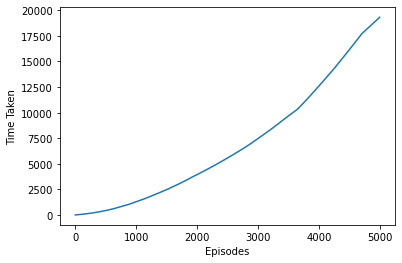

In [191]:
plt.plot(np.arange(0, 5000, 10), track_time)
plt.xlabel("Episodes")
plt.ylabel("Time Taken")
plt.show()

#### Time taken during Neural Network Training

It fluctuated but dosen't constantly increase or decrease.

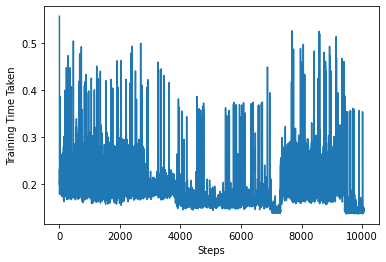

In [192]:
plt.plot(np.arange(len(track_train_time)), track_train_time)
plt.xlabel("Steps")
plt.ylabel("Training Time Taken")
plt.show()

#### Plot 1 - Time spent on taking action vs episode, Plot 2 - Number of greedy actions per episode 

Absolut time taken to perform action during each episode. It clearly shows that as the number of greedy action increases the time taken for taking action constantly increases per episode.

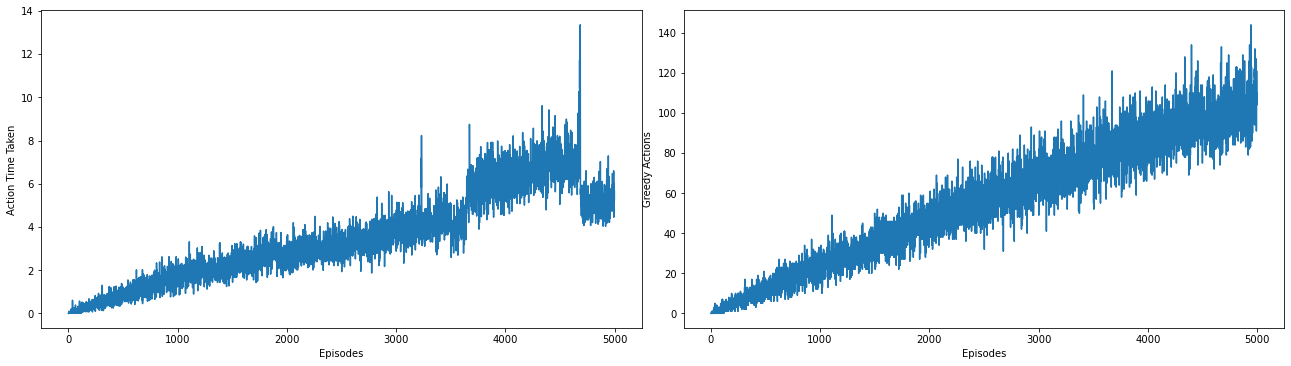

In [196]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(track_action_time)), track_action_time)
plt.xlabel("Episodes")
plt.ylabel("Action Time Taken")
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(greedy_actions)), greedy_actions)
plt.xlabel("Episodes")
plt.ylabel("Greedy Actions")
plt.show()

#### Loss tracked during model training

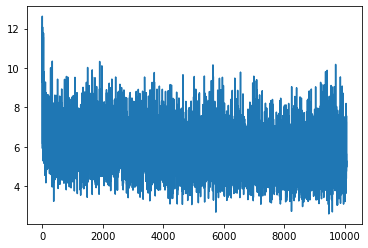

In [168]:
track_loss = [loss.history['loss'] for loss in training_loss]
plt.plot(np.arange(len(track_loss)), track_loss)
plt.show()

### Tracking Convergence

In [169]:
def plot_qvalue_convergence(state, action):
    q_values = states_track[state][action]
    plt.plot(range(0, len(q_values)), q_values)
    plt.ylabel("Q_value")
    plt.title("State : "+str(state)+" | Action : "+str(action))
    plt.legend(["Q-value"], loc="lower left")

In [177]:
states_track

{(2,
  3,
  4): {(0, 0): [25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   25.166677474975586,
   15.976029396057129,
   15.976029396057129,
   15.976029396057129,
   15.976029396057129,
   15.976029396057129,
   15.976029396057129,
   22.623311042785645,
   22.623311042785645,
   22.623311042785645,
   22.623311042785645,
   22.623311042785645,
   22.623311042785645,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595272064209,
   15.62595

<Figure size 1440x576 with 0 Axes>

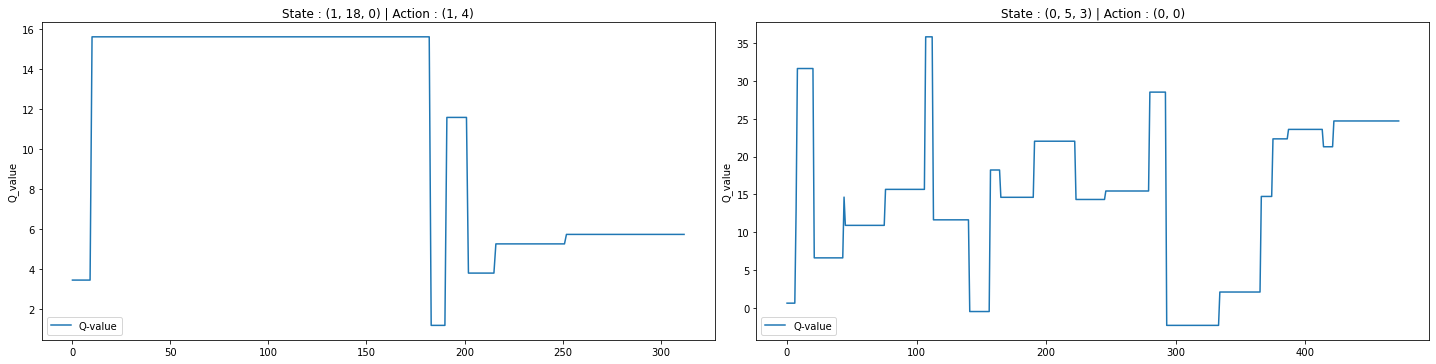

In [184]:
plt.figure(0, figsize=(20, 8))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.tight_layout()
idx = 1
for state in states_track.keys():
    if state not in {(0,5,3), (1, 18, 0)}:
        continue
    for action in states_track[state].keys():
        plt.subplot(1, 2, idx)
        plot_qvalue_convergence(state, action)
        idx+=1
plt.show()

### Epsilon - decay check

<Figure size 1440x504 with 0 Axes>

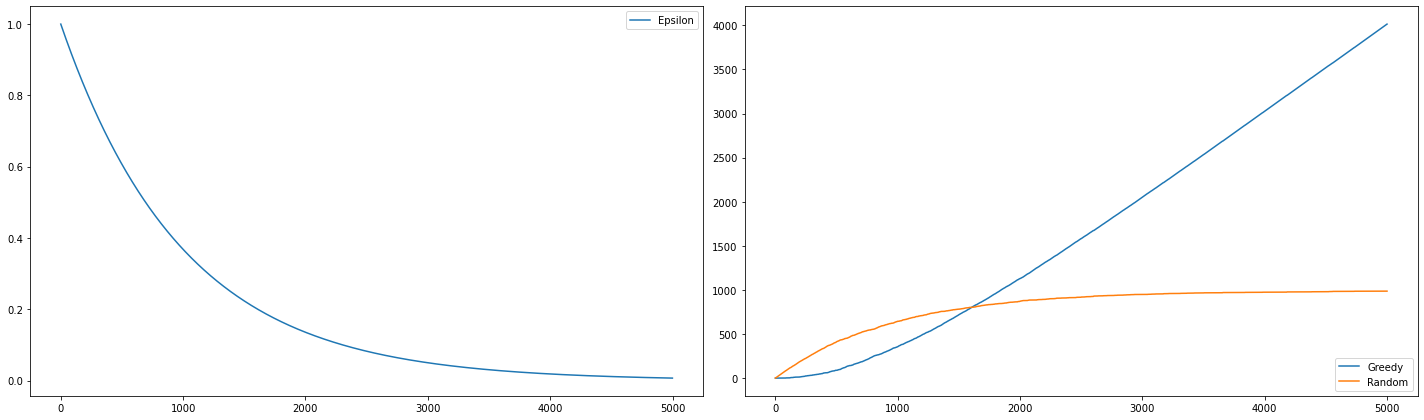

In [188]:
greedy_action_track = {'greedy':[0], 'random':[0]}
greedy_random_count = [0, 0]
episodes = 5000
epsilons = []

def epsilon_greedy(episode, emax=1.0, emin=0.000001):
    epsilon = emin + (emax - emin) * np.exp(-0.001 * episode)
    z = np.random.random()
    if z > epsilon:
        greedy_random_count[0]+=1
    else:
        greedy_random_count[1]+=1
    return epsilon

for episode in range(episodes):
    epsilons.append(epsilon_greedy(episode))
    greedy_action_track['greedy'].append(greedy_random_count[0])
    greedy_action_track['random'].append(greedy_random_count[1])
        
plt.figure(0, figsize=(20, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, episodes), epsilons)
plt.legend(["Epsilon"], loc="upper right")
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 5001), greedy_action_track['greedy'])
plt.plot(np.arange(0, 5001), greedy_action_track['random'])
plt.legend(["Greedy", "Random"], loc="lower right")
plt.show()